In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %reload_ext autoreload

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import skimage.io as io

import filters
import homography
import rectification
import utils

# Input Files

In [4]:
name  = "plush"
i, j = "1", "2"

DATA = Path("data") / name
OUTDIR = Path("output")

DATA.mkdir(parents=False, exist_ok=True)
assert OUTDIR.exists()

In [5]:
im1_name = DATA / (name + i + ".jpg")
im2_name = DATA / (name + j + ".jpg")
im1_name

PosixPath('data/plush/plush1.jpg')

In [6]:
# plane_name = DATA / (name + "_plane.pkl")

# a = im1_name.stem + "_" + i + j
# b = im2_name.stem + "_" + i + j

# warp1_name = DATA / (a + "_w.jpg")
# warp2_name = DATA / (b + "_w.jpg")

# pts1_name = DATA / (a + "_w.pkl")
# pts2_name = DATA / (b + "_w.pkl")

In [7]:
mosaic_name = OUTDIR / (name + "_mosaic.jpg")

In [8]:
pts1_name

NameError: name 'pts1_name' is not defined

# Pick Correspondences

In [9]:
im1 = utils.read_img(im1_name)
im2 = utils.read_img(im2_name)

In [12]:
%matplotlib tk
im1_pts = utils.pick_points(im1, 4)
%matplotlib inline

Please select 4 points in image.
Picked 4 points successfully.


In [13]:
%matplotlib tk
im2_pts = utils.pick_points(im2, 4)
%matplotlib inline

Please select 4 points in image.
Picked 4 points successfully.


In [16]:
h, w, c = im1.shape

num_pixels = 1600 * 1600
RESIZE = h * w > num_pixels

print(f"{RESIZE = }")
if RESIZE:
    r =  int(h * w / num_pixels)
    print("ratio = ", r)
    print(f"input shape = {im1.shape}")
    print(f"target shape = ({h / r}, {w / r})")

RESIZE = True
ratio =  3
input shape = (2268, 4032, 3)
target shape = (756.0, 1344.0)


In [17]:
if RESIZE:
    print("resizing...")
    im1 = sk.transform.resize(im1, (im1.shape[0] // r, im1.shape[1] // r), anti_aliasing=True)
    im2 = sk.transform.resize(im2, (im2.shape[0] // r, im2.shape[1] // r), anti_aliasing=True)
    im1_pts /= r
    im2_pts /= r

im1.shape

resizing...


(756, 1344, 3)

# Image Rectification

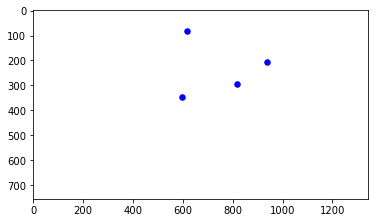

In [19]:
plane_pts = (im1_pts + im2_pts) / 2
canvas = np.ones_like(im1)
utils.plot_pts(canvas, plane_pts)

# Warping to the same plane

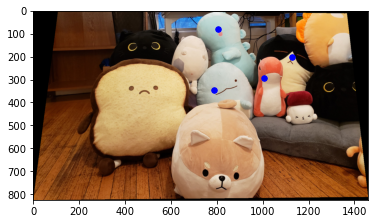

In [22]:
h_matrix1 = homography.homo_matrix(im1_pts, plane_pts)
warp1, shift_pts1 = homography.inverse_warp(im1, h_matrix1)
warp_pts1 = homography.warp_pts(im1_pts, h_matrix1, shift_pts1)
utils.plot_pts(warp1, warp_pts1)

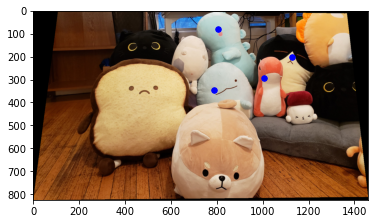

In [23]:
h_matrix2 = homography.homo_matrix(im2_pts, plane_pts)
warp2, shift_pts2= homography.inverse_warp(im2, h_matrix2)
warp_pts2 = homography.warp_pts(im2_pts, h_matrix2, shift_pts2)
utils.plot_pts(warp1, warp_pts1)

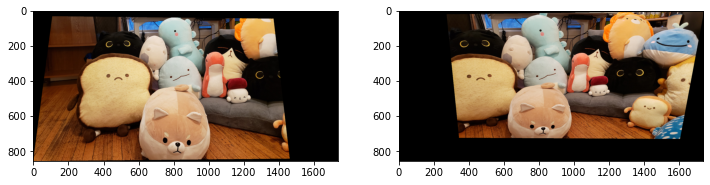

In [25]:
aligned1, aligned2 = rectification.align(warp1, warp2, warp_pts1, warp_pts2)
utils.show_two(aligned1, aligned2)

In [28]:
blended = rectification.average_blend(aligned1, aligned2)

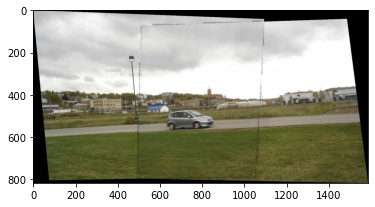

In [29]:
plt.imshow(blended)
plt.imsave(mosaic_name, blended)